In [38]:
# Make a catalogue with real and model PSFs + magnitude etc, for PSF testing script
# Sex file and star file in des read_files() needs to be altered

!jupyter nbconvert --to script TestStarSelect_deep.ipynb

#! /usr/bin/env python
%matplotlib inline
from __future__ import print_function
import os
import numpy as np
#from read_psf_cats import read_data, band_combinations
import fitsio
import treecorr
import matplotlib
import matplotlib
#matplotlib.use('Agg') # needs to be done before import pyplot
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table,join
import h5py as h

from __future__ import print_function
import os
import sys
import shutil
import logging
import datetime
import traceback
import numpy as np
import copy
import glob
import time
import fitsio
#import pixmappy
import pandas
#import galsim
#import galsim.des
#import piff
#import ngmix


[NbConvertApp] Converting notebook TestStarSelect_deep.ipynb to script
[NbConvertApp] Writing 8780 bytes to TestStarSelect_deep.py


In [11]:
""" COLUMNS IN SEX FILE 
    ColDefs(
    name = 'VIGNET'; format = '3969E'; unit = 'count'; disp = 'G12.7'; dim = '(63, 63)'
    name = 'XWIN_IMAGE'; format = '1D'; unit = 'pixel'; disp = 'F11.4'
    name = 'YWIN_IMAGE'; format = '1D'; unit = 'pixel'; disp = 'F11.4'
    name = 'X_IMAGE'; format = '1E'; unit = 'pixel'; disp = 'F11.4'
    name = 'Y_IMAGE'; format = '1E'; unit = 'pixel'; disp = 'F11.4'
    name = 'FLUX_APER'; format = '12E'; unit = 'count'; disp = 'G12.7'
    name = 'FLUXERR_APER'; format = '12E'; unit = 'count'; disp = 'G12.7'
    name = 'FLUX_MAX'; format = '1E'; unit = 'count'; disp = 'G12.7'
    name = 'MAG_APER'; format = '12E'; unit = 'mag'; disp = 'F8.4'
    name = 'MAGERR_APER'; format = '12E'; unit = 'mag'; disp = 'F8.4'
    name = 'FLUX_RADIUS'; format = '1E'; unit = 'pixel'; disp = 'F10.3'
    name = 'ELONGATION'; format = '1E'; disp = 'F8.3'
    name = 'FLAGS'; format = '1I'; disp = 'I3'
    name = 'SNR_WIN'; format = '1E'; disp = 'G10.4'
    name = 'ERRAWIN_WORLD'; format = '1E'; unit = 'deg'; disp = 'G12.7'
    name = 'ERRBWIN_WORLD'; format = '1E'; unit = 'deg'; disp = 'G12.7'
    name = 'ERRTHETAWIN_J2000'; format = '1E'; unit = 'deg'; disp = 'F6.2'
    
    COLUMNS IN STAR FILE
    ColDefs(
    name = 'SOURCE_NUMBER'; format = '1J'; disp = 'I10'
    name = 'EXTENSION'; format = '1I'; disp = 'I4'
    name = 'CATALOG_NUMBER'; format = '1J'; disp = 'I7'
    name = 'FLAGS_PSF'; format = '1J'; disp = 'I7'
    name = 'VECTOR_CONTEXT'; format = '2D'; disp = 'G12.6'
    name = 'X_IMAGE'; format = '1D'; unit = 'pixel'; disp = 'F11.4'
    name = 'Y_IMAGE'; format = '1D'; unit = 'pixel'; disp = 'F11.4'
    name = 'DELTAX_IMAGE'; format = '1E'; unit = 'pixel'; disp = 'F11.4'
    name = 'DELTAY_IMAGE'; format = '1E'; unit = 'pixel'; disp = 'F11.4'
    name = 'NORM_PSF'; format = '1E'; unit = 'count'; disp = 'G12.6'
    name = 'FWHM_PSF'; format = '1E'; unit = 'pixel'; disp = 'F8.2'
    name = 'ELLIP_PSF'; format = '1E'; disp = 'F7.5'
    name = 'SNR_PSF'; format = '1E'; disp = 'G10.4'
    name = 'CHI2_PSF'; format = '1E'; disp = 'G12.6'
    name = 'RESI_PSF'; format = '1E'; disp = 'G12.6'
"""


" COLUMNS IN SEX FILE ColDefs(\n    name = 'VIGNET'; format = '3969E'; unit = 'count'; disp = 'G12.7'; dim = '(63, 63)'\n    name = 'XWIN_IMAGE'; format = '1D'; unit = 'pixel'; disp = 'F11.4'\n    name = 'YWIN_IMAGE'; format = '1D'; unit = 'pixel'; disp = 'F11.4'\n    name = 'X_IMAGE'; format = '1E'; unit = 'pixel'; disp = 'F11.4'\n    name = 'Y_IMAGE'; format = '1E'; unit = 'pixel'; disp = 'F11.4'\n    name = 'FLUX_APER'; format = '12E'; unit = 'count'; disp = 'G12.7'\n    name = 'FLUXERR_APER'; format = '12E'; unit = 'count'; disp = 'G12.7'\n    name = 'FLUX_MAX'; format = '1E'; unit = 'count'; disp = 'G12.7'\n    name = 'MAG_APER'; format = '12E'; unit = 'mag'; disp = 'F8.4'\n    name = 'MAGERR_APER'; format = '12E'; unit = 'mag'; disp = 'F8.4'\n    name = 'FLUX_RADIUS'; format = '1E'; unit = 'pixel'; disp = 'F10.3'\n    name = 'ELONGATION'; format = '1E'; disp = 'F8.3'\n    name = 'FLAGS'; format = '1I'; disp = 'I3'\n    name = 'SNR_WIN'; format = '1E'; disp = 'G10.4'\n    name = '

In [36]:
def read_files(filter):
    
    #sex_file="/global/cscratch1/sd/amichoi/UltraVISTA/cat/UVISTA_%s_21_01_16_psfcat.fits" % (filter)   
    sex_file="/global/cscratch1/sd/amichoi/VIDEO/cat/VIDEO_%s_10_36.80_-5.01_psfcat.fits" % (filter) 
        
    dat = fits.open(sex_file)
    cols = dat[2].columns
    #print(cols)
    sex=Table(dat[2].data)
    print("Length of sex file: ", len(sex))

    #read in list of stars made from Sextractor and PSFEx
    #star_file="/global/homes/a/aamon/DES/DEStests/DEEP/deeppsfs/UltraVista/UVISTA_%s_21_01_16_psfex-starlist.fits" % (filter)
    star_file="/global/cscratch1/sd/amichoi/VIDEO/psf/VIDEO_%s_10_36.80_-5.01_psfex-starlist.fits" % (filter)

    dat = fits.open(star_file)
    cols = dat[2].columns
    #print(cols)
    star=Table(dat[2].data)
    print("Length of star file: ", len(star))

    print(sex['X_IMAGE'],star['X_IMAGE'])
    #sex.rename_column('XWIN_IMAGE', 'X')  #USE  FOR ULTRAVISTA
    #star.rename_column('X_IMAGE', 'X')   
    #sexstarmerge = join(sex, star, keys=['X'],  join_type='inner') #
    
    sex['X_IMAGE']=sex['X_IMAGE'].astype(int)
    star['X_IMAGE']=star['X_IMAGE'].astype(int)
    sex['Y_IMAGE']=sex['Y_IMAGE'].astype(int)
    star['Y_IMAGE']=star['Y_IMAGE'].astype(int)
    sexstarmerge = join(sex, star, keys=['X_IMAGE','Y_IMAGE'],  join_type='inner')
    
    print("length of merged cat: ", len(sexstarmerge))
 
    cols = tuple(name for name in sexstarmerge.colnames if len(sexstarmerge[name].shape) <= 1)
    t2 = sexstarmerge[cols]
    sexstardf = t2.to_pandas()
    
    return sexstarmerge, sex,star

In [17]:
"""import seaborn as sns; sns.set()
print(min)
sns.scatterplot(x='FWHM_PSF',y='SNR_PSF', hue='FLAGS_PSF',  data=stardf)
plt.xscale('log')
plt.yscale('log')
plt.ylim(10,10**7 )"""

"""plt.scatter(stardf['FWHM_PSF'],stardf['SNR_PSF'],c=stardf['FLAGS_PSF'] , marker='.', label=stardf['FLAGS_PSF'])
plt.xlabel('FWHM')
plt.ylabel('SNR')
plt.ticklabel_format(useOffset=False)
plt.xscale('log')
plt.yscale('log')
plt.ylim(10,10**7 )
plt.legend(stardf['FLAGS_PSF'])"""

"plt.scatter(stardf['FWHM_PSF'],stardf['SNR_PSF'],c=stardf['FLAGS_PSF'] , marker='.', label=stardf['FLAGS_PSF'])\nplt.xlabel('FWHM')\nplt.ylabel('SNR')\nplt.ticklabel_format(useOffset=False)\nplt.xscale('log')\nplt.yscale('log')\nplt.ylim(10,10**7 )\nplt.legend(stardf['FLAGS_PSF'])"

0
H
Length of sex file:  2776
Length of star file:  2776
X_IMAGE
-------
1658.45
2441.13
2557.25
1507.28
2574.64
474.351
 1599.3
768.509
2519.03
1642.66
    ...
 994.24
205.404
1571.32
368.868
2372.52
1067.65
2188.53
2630.32
248.759
2066.04
2365.65
Length = 2776 rows    X_IMAGE   
-------------
1658.44592285
2441.12988281
2557.25488281
1507.28344727
2574.64477539
474.350830078
1599.30114746
768.509277344
2519.03173828
1642.66088867
          ...
994.240112305
205.403656006
1571.32177734
368.867553711
2372.51660156
1067.64648438
2188.53320312
2630.31640625
248.759414673
2066.04077148
2365.64648438
Length = 2776 rows
length of merged cat:  2776
2130
length of merged cat:  2776
length of non-stars:  2130
length of stars:  646
1
J
Length of sex file:  3172
Length of star file:  3172
X_IMAGE
-------
2440.32
2556.43
 1505.9
2572.53
473.185
1598.16
767.496
2518.09
864.619
1690.01
    ...
1645.99
547.187
 2583.8
1903.18
2282.33
442.877
1285.68
2299.03
2563.13
1813.91
462.511
Length = 3172 rows

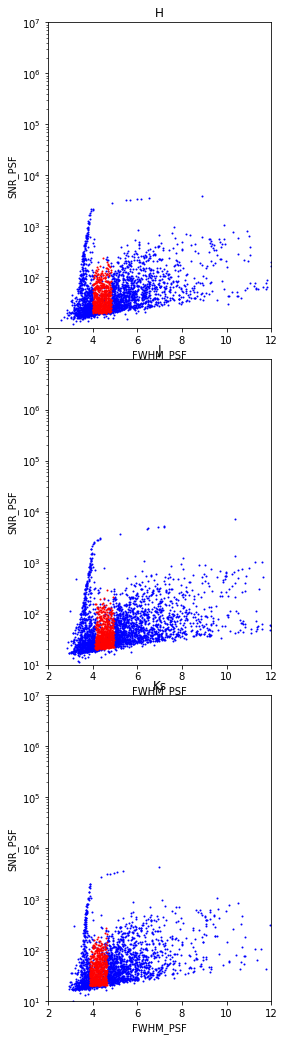

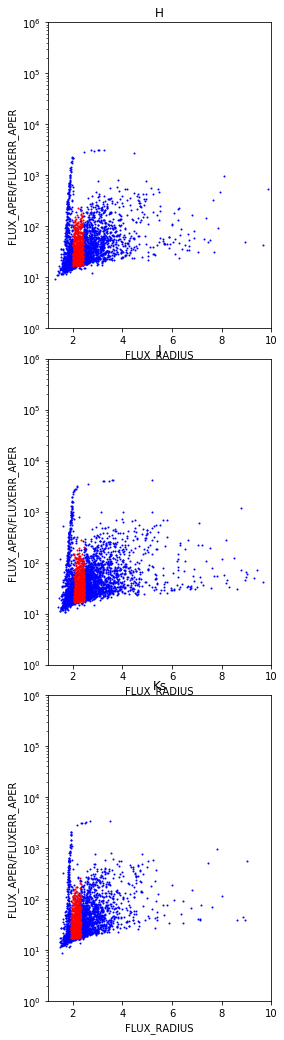

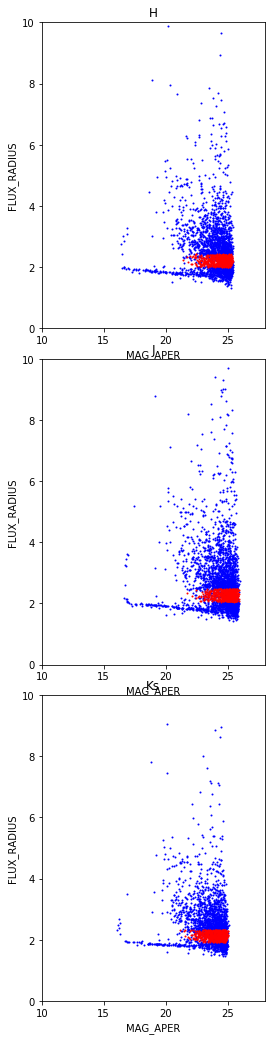

In [37]:
filter=['H', 'J', 'Ks']#, 'Y']
numfilts=len(filter)

#make figure for fwhm-snr
fig, axs = plt.subplots(3, figsize=(4, 18), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=.5)
fig2, axs2 = plt.subplots(3, figsize=(4, 18), facecolor='w', edgecolor='k')
fig2.subplots_adjust(hspace = .1, wspace=.5)
fig3, axs3 = plt.subplots(3, figsize=(4, 18), facecolor='w', edgecolor='k')
fig3.subplots_adjust(hspace = .1, wspace=.5)

#make figure for flux-size
for i in range(numfilts):
    print(i)
    filt=filter[i]
    print(filt)
    
    #sexdata,stardata=read_files(filt)
    sexstar, sex, star =read_files(filt)
    
    #print(ssdf)
    print(len(sexstar['FLAGS_PSF'][np.where(sexstar['FLAGS_PSF']!=0)]))
    #match data so can use FLAGS_PSF
    print("length of merged cat: ", len(sexstar))
    print("length of non-stars: ",len(sexstar['FLAGS_PSF'][np.where(sexstar['FLAGS_PSF']!=0)]))
    print("length of stars: ",len(sexstar['FLAGS_PSF'][np.where(sexstar['FLAGS_PSF']==0)]))
    
    #add to axes    
    #axs[i].scatter(x=star['FWHM_PSF'],y=star['SNR_PSF'],c='red',label='FLAGS_PSF=0', marker='.',s=4)##,ax=axs[i]) # use this is conconcered about matching 
    axs[i].scatter(x=sexstar['FWHM_PSF'][np.where(sexstar['FLAGS_PSF']!=0)],y=sexstar['SNR_PSF'][np.where(sexstar['FLAGS_PSF']!=0)],c='blue',label='FLAGS_PSF>0', marker='.',s=4)##,ax=axs[i])
    axs[i].scatter(x=sexstar['FWHM_PSF'][np.where(sexstar['FLAGS_PSF']==0)],y=sexstar['SNR_PSF'][np.where(sexstar['FLAGS_PSF']==0)],c='red',label='FLAGS_PSF=0', marker='.',s=4)##,ax=axs[i])
    #axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].set_xlim(2,12)
    axs[i].set_ylim(10,10**7 )
    axs[i].set_xlabel('FWHM_PSF')
    axs[i].set_ylabel('SNR_PSF')
    axs[i].set_title(filt)
    #axs[i].legend(sexstar['FLAGS_PSF'])
    
    #axs2[i].scatter(x=sex['FLUX_RADIUS'],y=sex['FLUX_APER'][:,3],c='blue',label='FLAGS_PSF=0', marker='.',s=4) use this is conconcered about matching 
    axs2[i].scatter(sexstar['FLUX_RADIUS'][np.where(sexstar['FLAGS_PSF']!=0)],sexstar['FLUX_APER'][[np.where(sexstar['FLAGS_PSF']!=0)],3]/sexstar['FLUXERR_APER'][[np.where(sexstar['FLAGS_PSF']!=0)],3],c='blue',label='FLAGS_PSF>0', marker='.',s=4) # , colormap='viridis')
    axs2[i].scatter(sexstar['FLUX_RADIUS'][np.where(sexstar['FLAGS_PSF']==0)],sexstar['FLUX_APER'][[np.where(sexstar['FLAGS_PSF']==0)],3]/sexstar['FLUXERR_APER'][[np.where(sexstar['FLAGS_PSF']==0)],3],c='red',label='FLAGS_PSF=0', marker='.',s=4)
    ##plt.xscale('log')
    axs2[i].set_yscale('log')
    axs2[i].set_ylim(1,10**6)
    axs2[i].set_xlim(1,10)
    #axs2[i].legend(sexstar['FLAGS_PSF'])
    axs2[i].set_xlabel('FLUX_RADIUS')
    axs2[i].set_ylabel('FLUX_APER/FLUXERR_APER')
    axs2[i].set_title(filt)
    
    axs3[i].scatter(sexstar['MAG_APER'][[np.where(sexstar['FLAGS_PSF']!=0)],0], sexstar['FLUX_RADIUS'][np.where(sexstar['FLAGS_PSF']!=0)],c='blue',label='FLAGS_PSF>0', marker='.',s=4) # , colormap='viridis')
    axs3[i].scatter(sexstar['MAG_APER'][[np.where(sexstar['FLAGS_PSF']==0)],0], sexstar['FLUX_RADIUS'][np.where(sexstar['FLAGS_PSF']==0)],c='red',label='FLAGS_PSF=0', marker='.',s=4)
    axs3[i].set_ylim(0,10)
    axs3[i].set_xlim(10,28)
    #axs2[i].legend(sexstar['FLAGS_PSF'])
    axs3[i].set_ylabel('FLUX_RADIUS')
    axs3[i].set_xlabel('MAG_APER')
    axs3[i].set_title(filt)

fig.savefig("Figs/VIDEO_SNR_psffwhm.pdf")    
fig2.savefig("Figs/VIDEO_SN_size.pdf")       
fig3.savefig("Figs/VIDEO_size_mag.pdf")
